In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import special
from scipy.optimize import curve_fit
from scipy import special

In [2]:
path = Path.cwd()
date = "2022-02-22"
datapath = path / (date+'_TK-data')
outputpath = path / 'results'

In [3]:
u = 1.6605 * 1e-27
m85 = 84.91 * u	
m87 = 86.91 * u	 
kB = 1.380649 * 1e-23

In [4]:
def calc_N(V):
    c = 299792458
    h = 6.62607015 *1e-34

    SF = 10 * 1e6/(10*1e6+50) #scale factor
    TG = 4.75 * 1e6 #V/A #Transimpedance gain Hi-Z
    TG_err = 0.05 * TG #5% error
    R = 0.48 #Wellenlänge lambda = 780 nm
    R_err = 0.01

    Delta = 10 * 1e6 #10 MHz detuning
    Gamma0 = 2*np.pi*6.07 *1e6 #2pi * 6.07 MHz natural line width
    Isat = 4.1 *1e-3*1e4 # 4.1 mW/cm^2
    P_pm = 15 * 1e-3 # P_Powermeter = 5 +/- 0.1 mW je Richtung
    P_pm_err = np.sqrt(3)*0.1*1e-3 #siehe oben
    w = 2*1e-3 #waist 2 mmm
    I0 = 2*P_pm/(np.pi*w**2) #Ir \approx I0 Ist das richtig so? oder Faktor 3 daneben?
    I0_err = 2*P_pm_err/(np.pi*w**2)

    theta = (25.4)**2/(4*(150)**2) #according to Praktikumsanleitung
    E = h*c/(780.241*1e-9) #5S1/2 -> 5P3/2 Übergang aprrox 780.241 nm

    Pmeas = V /(R * TG * SF)
    Pmeas_err = np.sqrt((V*R_err/(R**2*TG*SF))**2+(V*TG_err/(R*TG**2*SF))**2)
    Gamma_sc = Gamma0/2 * I0/Isat /(1+I0/Isat+4*Delta**2/Gamma0**2)
    Gamma_sc_err = Gamma0/(2*Isat) * (1+4*Delta**2/Gamma0**2)/(1+I0/Isat*4*Delta**2/Gamma0**2) * I0_err
    Na = Pmeas/(theta*Gamma_sc*E)
    Na_err = np.sqrt((Pmeas_err/(theta*Gamma_sc*E))**2+(Pmeas*Gamma_sc_err/(theta*Gamma_sc**2*E))**2)

    return Na,Na_err

In [8]:
def extract_ratio(data,inputsignal,lenghtl,lengthr,bgmean,bgstd):
    diff = np.array([abs(inputsignal[i+1]-inputsignal[i]) for i in range(0,inputsignal.shape[0]-1)])
    diff = np.concatenate((diff,[False]))
    start = data.index[diff > 1][-2]
    stop = data.index[diff > 1][-1]

    N0 = np.mean(data[start-lenghtl:start])-bgmean
    N1 = np.mean(data[stop:stop+lengthr+1])-bgmean

    N0_err = np.sqrt((1/np.sqrt(lenghtl)*np.std(data[start-lenghtl:start]))**2+bgstd**2)
    N1_err = np.sqrt((1/np.sqrt(lengthr)*np.std(data[stop:stop+lengthr+1]))**2+bgstd**2)

    ratio = N1/N0
    ratio_err = np.sqrt((N1_err/N0)**2+(N1/N0**2*N0_err)**2)

    return ratio, ratio_err
    

In [9]:
data = pd.read_csv(datapath/(date+"_CAR_background.csv"),header=2,skiprows=[8],sep=';')
Nbg = calc_N(data['HS3-100(17654).Ch2'])[0]
bgmean = np.mean(Nbg)
bgstd = np.std(Nbg)
print(bgmean, bgstd)

456265.3166061956 22605.279185467796


In [10]:
length = 10

In [11]:
def fit_function(t,T):
    R = 1.5*1e-3 #1.5 mm
    chi = np.sqrt(m85/(kB*T))*R/t
    return special.erf(chi) - 2/np.sqrt(np.pi) * chi * np.exp(-chi**2) 

In [12]:
fileidx = np.array([5,10,15,18,20,22,25,30,35,40,43,45,48,50,53,55,58,60,63,65,68,70,73,75,80,85,90,100,150,200,250,300])

ratios = np.zeros(len(fileidx))
ratios_err = np.zeros(len(fileidx))
for i,fi in enumerate(fileidx):
    data = pd.read_csv(datapath/(date+"_CAR_{}.csv".format(fi)),header=2,skiprows=[8],sep=';')
    Na = calc_N(data['HS3-100(17654).Ch2'])[0]
    ratios[i],ratios_err[i] = extract_ratio(Na,data['HS3-100(17654).Ch1'],100,10,bgmean,bgstd)

<ipython-input-11-d7bc0d272f73>:3: RuntimeWarning: invalid value encountered in sqrt
  chi = np.sqrt(m85/(kB*T))*R/t


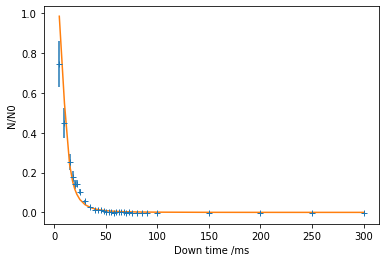

T = 174.31+/-11.44 μK


In [20]:
times = fileidx * 1e-3
popt, pcov = curve_fit(fit_function,times,ratios,sigma=ratios_err)
perr = np.sqrt(np.diag(pcov))
plt.errorbar(times*1e3,ratios,ratios_err,marker='+',ls='None')
plt.plot(times*1e3,fit_function(times,*popt))
plt.xlabel('Down time /ms')
plt.ylabel('N/N0')
plt.show()
print("T = {:.2f}+/-{:.2f} μK".format(popt[0]/1e-6,perr[0]/1e-6))